# LSTM Version 2.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
# We can use this function to make some prediction by using the trained model 

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
df = pd.read_csv('../../Data/Savitzky-Golay Data/SVG_poly1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(74783, 2)


,Year,Sunspot_Number
0,1818.001,34.566570
1,1818.004,34.546053
2,1818.007,34.525535
3,1818.010,34.505017
4,1818.012,34.484499


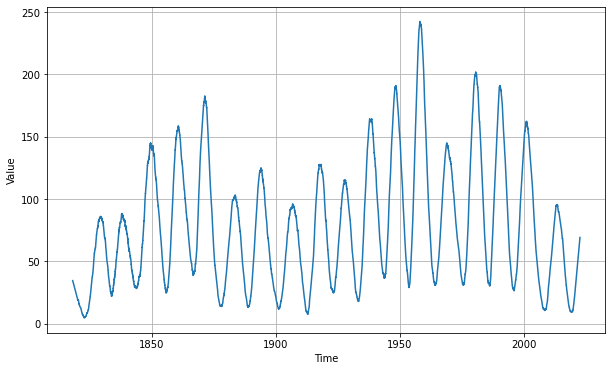

In [6]:
series = df['Sunspot_Number']
time = df['Year']

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 65000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 128

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(65000,)


In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss = tf.keras.losses.Huber()

In [10]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
    119/Unknown - 7s 39ms/step - loss: 15.8291 - mae: 16.3174

KeyboardInterrupt: 

In [ ]:
# Let's visualize "learning rate" vs "loss"
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 80])

In [ ]:
# Let's rerun the model with the optimul learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 64
batch_size = 64

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.8e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=200)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')
print("mae : ", tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)